
# BIOS512 Final Project
### Kevin Su

In [30]:
library('tidyverse')
library('patchwork')
library('scales')
library('ggrepel')
nhanes_labs = haven::read_xpt("P_ALB_CR.XPT") |>
  mutate(creatinine_lvl = ifelse(URXUCR > 20, "high", "not high"))

nhanes_nutr = haven::read_xpt("P_DR1TOT.XPT")

nhanes_demo = haven::read_xpt("P_DEMO.XPT") |>
  filter(RIDAGEYR >= 18 & RIDAGEYR < 80)

## check that SEQN are all unique; CDC data set documentation cautioned SEQN may not be primary key
#nhanes_nutr |> count(SEQN) |> filter(n==1) |> nrow() == nhanes_nutr |> nrow()

## Data

The data to be analyzed comes from the pre-pandemic 2017-2020 CDC National Health and Nutrition Examination Survey (NHANES). NHANES is administered nationally in the United States in yearly cycles. The data presented here pools the 2017-2018 and 2019-2020 (pre-pandemic) survey cycles due to low sample size. Analyses will focus specifically on adults from 18 to 79 years of age. Exact age of those 80 years of age or older is unavailable due to privacy concerns.

## Special Diets

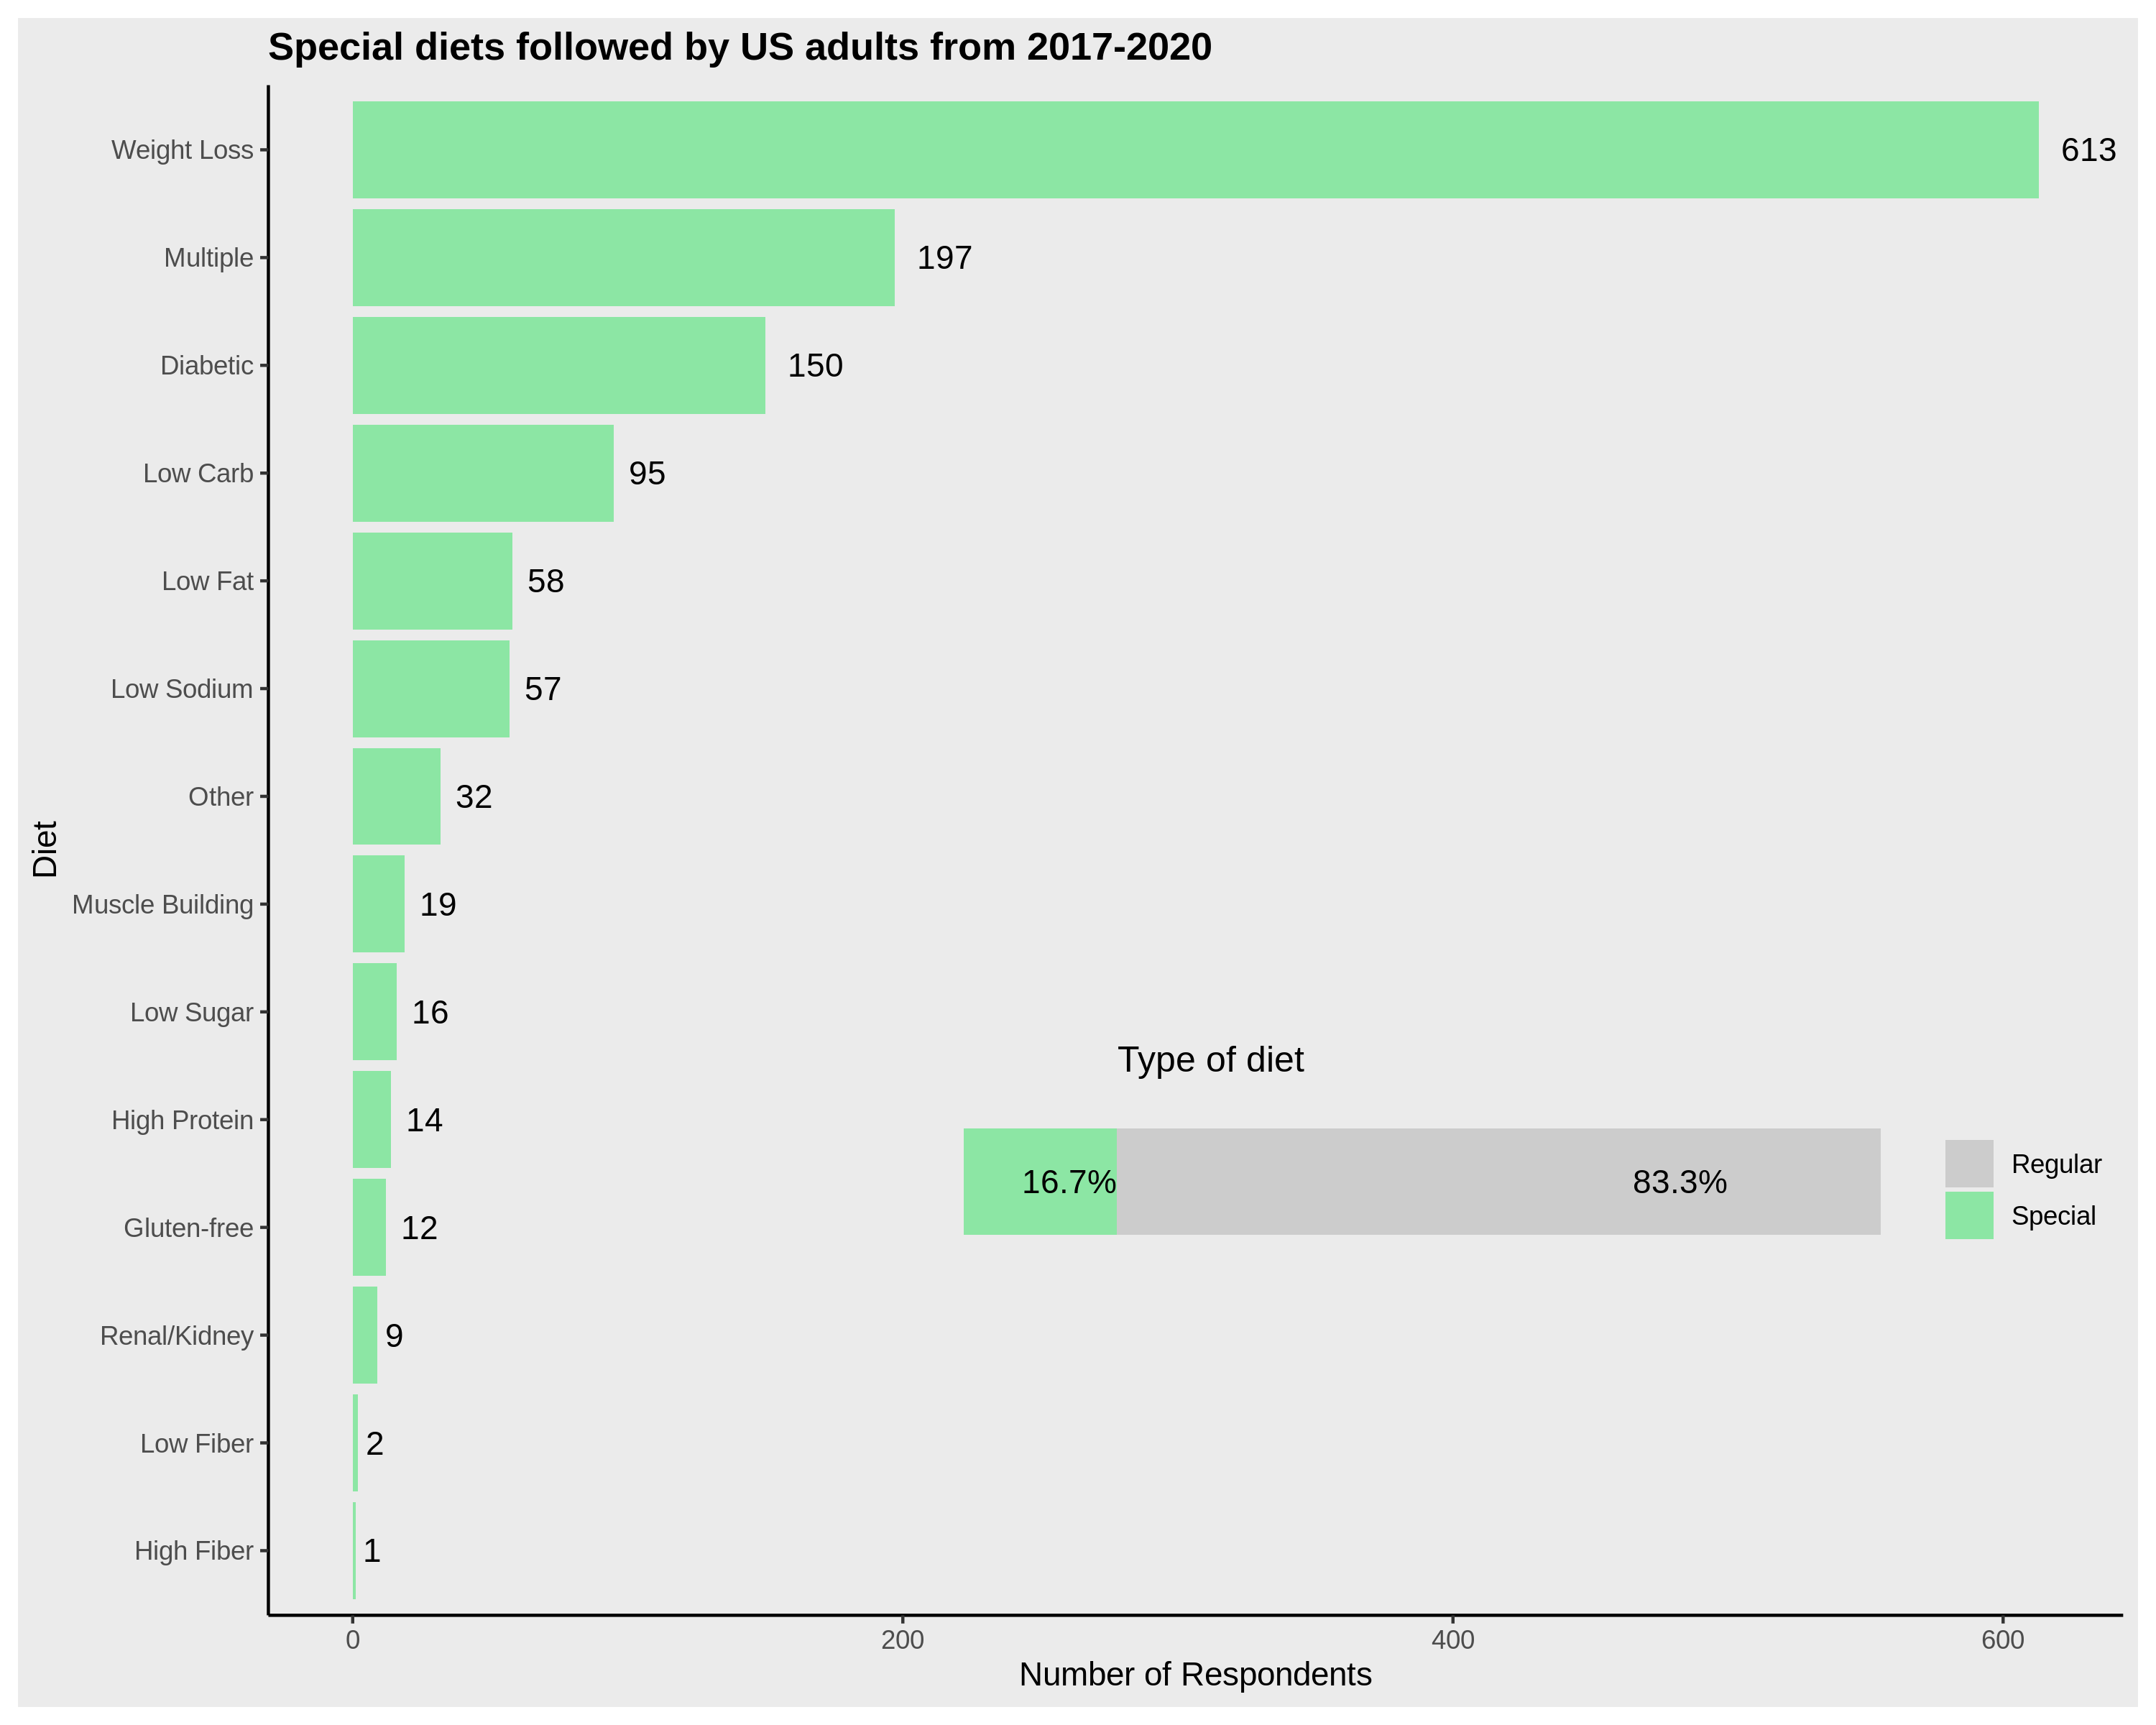

In [38]:
options(repr.plot.width=10, repr.plot.height=8)

diet_long = nhanes_nutr |> 
  semi_join(nhanes_demo, by = 'SEQN') |>
  select(SEQN, starts_with('DRQS')) |> 
  mutate(DRQSDT_reg = ifelse(DRQSDIET == 2, 0, NA)) |>
  pivot_longer(starts_with('DRQSDT'), names_to = 'Diet') |>
  na.omit() |> 
  group_by(SEQN) |> 
  mutate(ct = n()) |> 
  ungroup() |> 
  mutate(Diet = ifelse(ct > 1, "Multiple", Diet)) |> 
  distinct(SEQN, Diet, .keep_all = T) |> 
  mutate(Diet = Diet |> fct_recode(Regular = 'DRQSDT_reg',
                                   `Weight Loss` = 'DRQSDT1',
                                   `Low Fat` = 'DRQSDT2',
                                   `Low Sodium` = 'DRQSDT3',
                                   `Low Sugar` = 'DRQSDT4',
                                   `Low Fiber` = 'DRQSDT5',
                                   `High Fiber` = 'DRQSDT6',
                                   Diabetic = 'DRQSDT7',
                                   `Muscle Building` = 'DRQSDT8',
                                   `Low Carb` = 'DRQSDT9',
                                   `High Protein` = 'DRQSDT10',
                                   `Gluten-free` = 'DRQSDT11',
                                   `Renal/Kidney` = 'DRQSDT12',
                                   `Other` = 'DRQSDT91',
                                   Multiple = "Multiple"
                                   ))


diet_dicot = diet_long|>
  mutate(Diet = Diet |> fct_infreq() |> fct_lump_n(1, other_level = 'Special')) |> 
  count(Diet) |>
  mutate(prop = n/sum(n)) |>
  ggplot(aes(y = 'Diet', x = prop, fill = Diet)) + 
    geom_bar(stat = 'identity', width = .5) +
    geom_text(aes(label = paste0(round(prop*100,1), '%'),
                  hjust = 1)) +
    labs(title = "Type of diet") +
    scale_fill_manual(values = c('gray80', '#8ce6a4')) +
    theme_void() +
    theme(plot.title = element_text(size = 12, hjust = .2, vjust = -2),
          plot.title.position = 'plot',
          legend.title = element_blank())

special_diet_plot = diet_long |> 
  filter(Diet != 'Regular') |>
  mutate(Diet = Diet |> fct_infreq() |> fct_rev()) |> 
  ggplot(aes(y = Diet)) + 
  geom_bar(fill = '#8ce6a4') +
  geom_text(stat='count', aes(label=..count..), hjust=-.4) +
  labs(title = "Special diets followed by US adults from 2017-2020",
       x = "Number of Respondents") +
  theme_classic() +
  theme(plot.title = element_text(size = 13, face = 'bold'),
        plot.background = element_rect(fill="gray92"),
        panel.background = element_rect(fill="gray92"),
        panel.grid = element_line(color="gray"))

special_diet_plot + inset_element(diet_dicot, left = 0.35, bottom = 0.2, right = .99, top = 0.4)
  

I was first interested in exploring the types of diets US adults follow. There were 7,625 adults aged 18 to 79 for whom diet could be determined based on their NHANES responses. Around 83% of those respondents did not indicate following any type of special diet (deemed as "regular" in the above figure). Since this constitutes the vast majority of observations, I wanted to look into special diets alone while still displaying the breakdown of just regular vs special diet to provide a sense of scale. Among the approximately 17% who did follow some special diet, a weight loss diet was by far the most common (n = 613), followed by multiple diets (n = 197) and diabetic diet (n = 150), then low sodium, low carb, and low fat diets. One thing to note is that respondents were able to select multiple options on the special diet question, meaning that diet had to be recoded to account for this. Unfortunately, the consequence is that the exact combinations of multiple diets became obscured. Nonetheless, the top diets generally reflect a pattern among US adults in adopting special diets that presumably aligns with addressing potential health concerns, such as diabetes or CVD.

## Nutrient Intake

Warning message:
“Removed 764 rows containing missing values (`geom_point()`).”


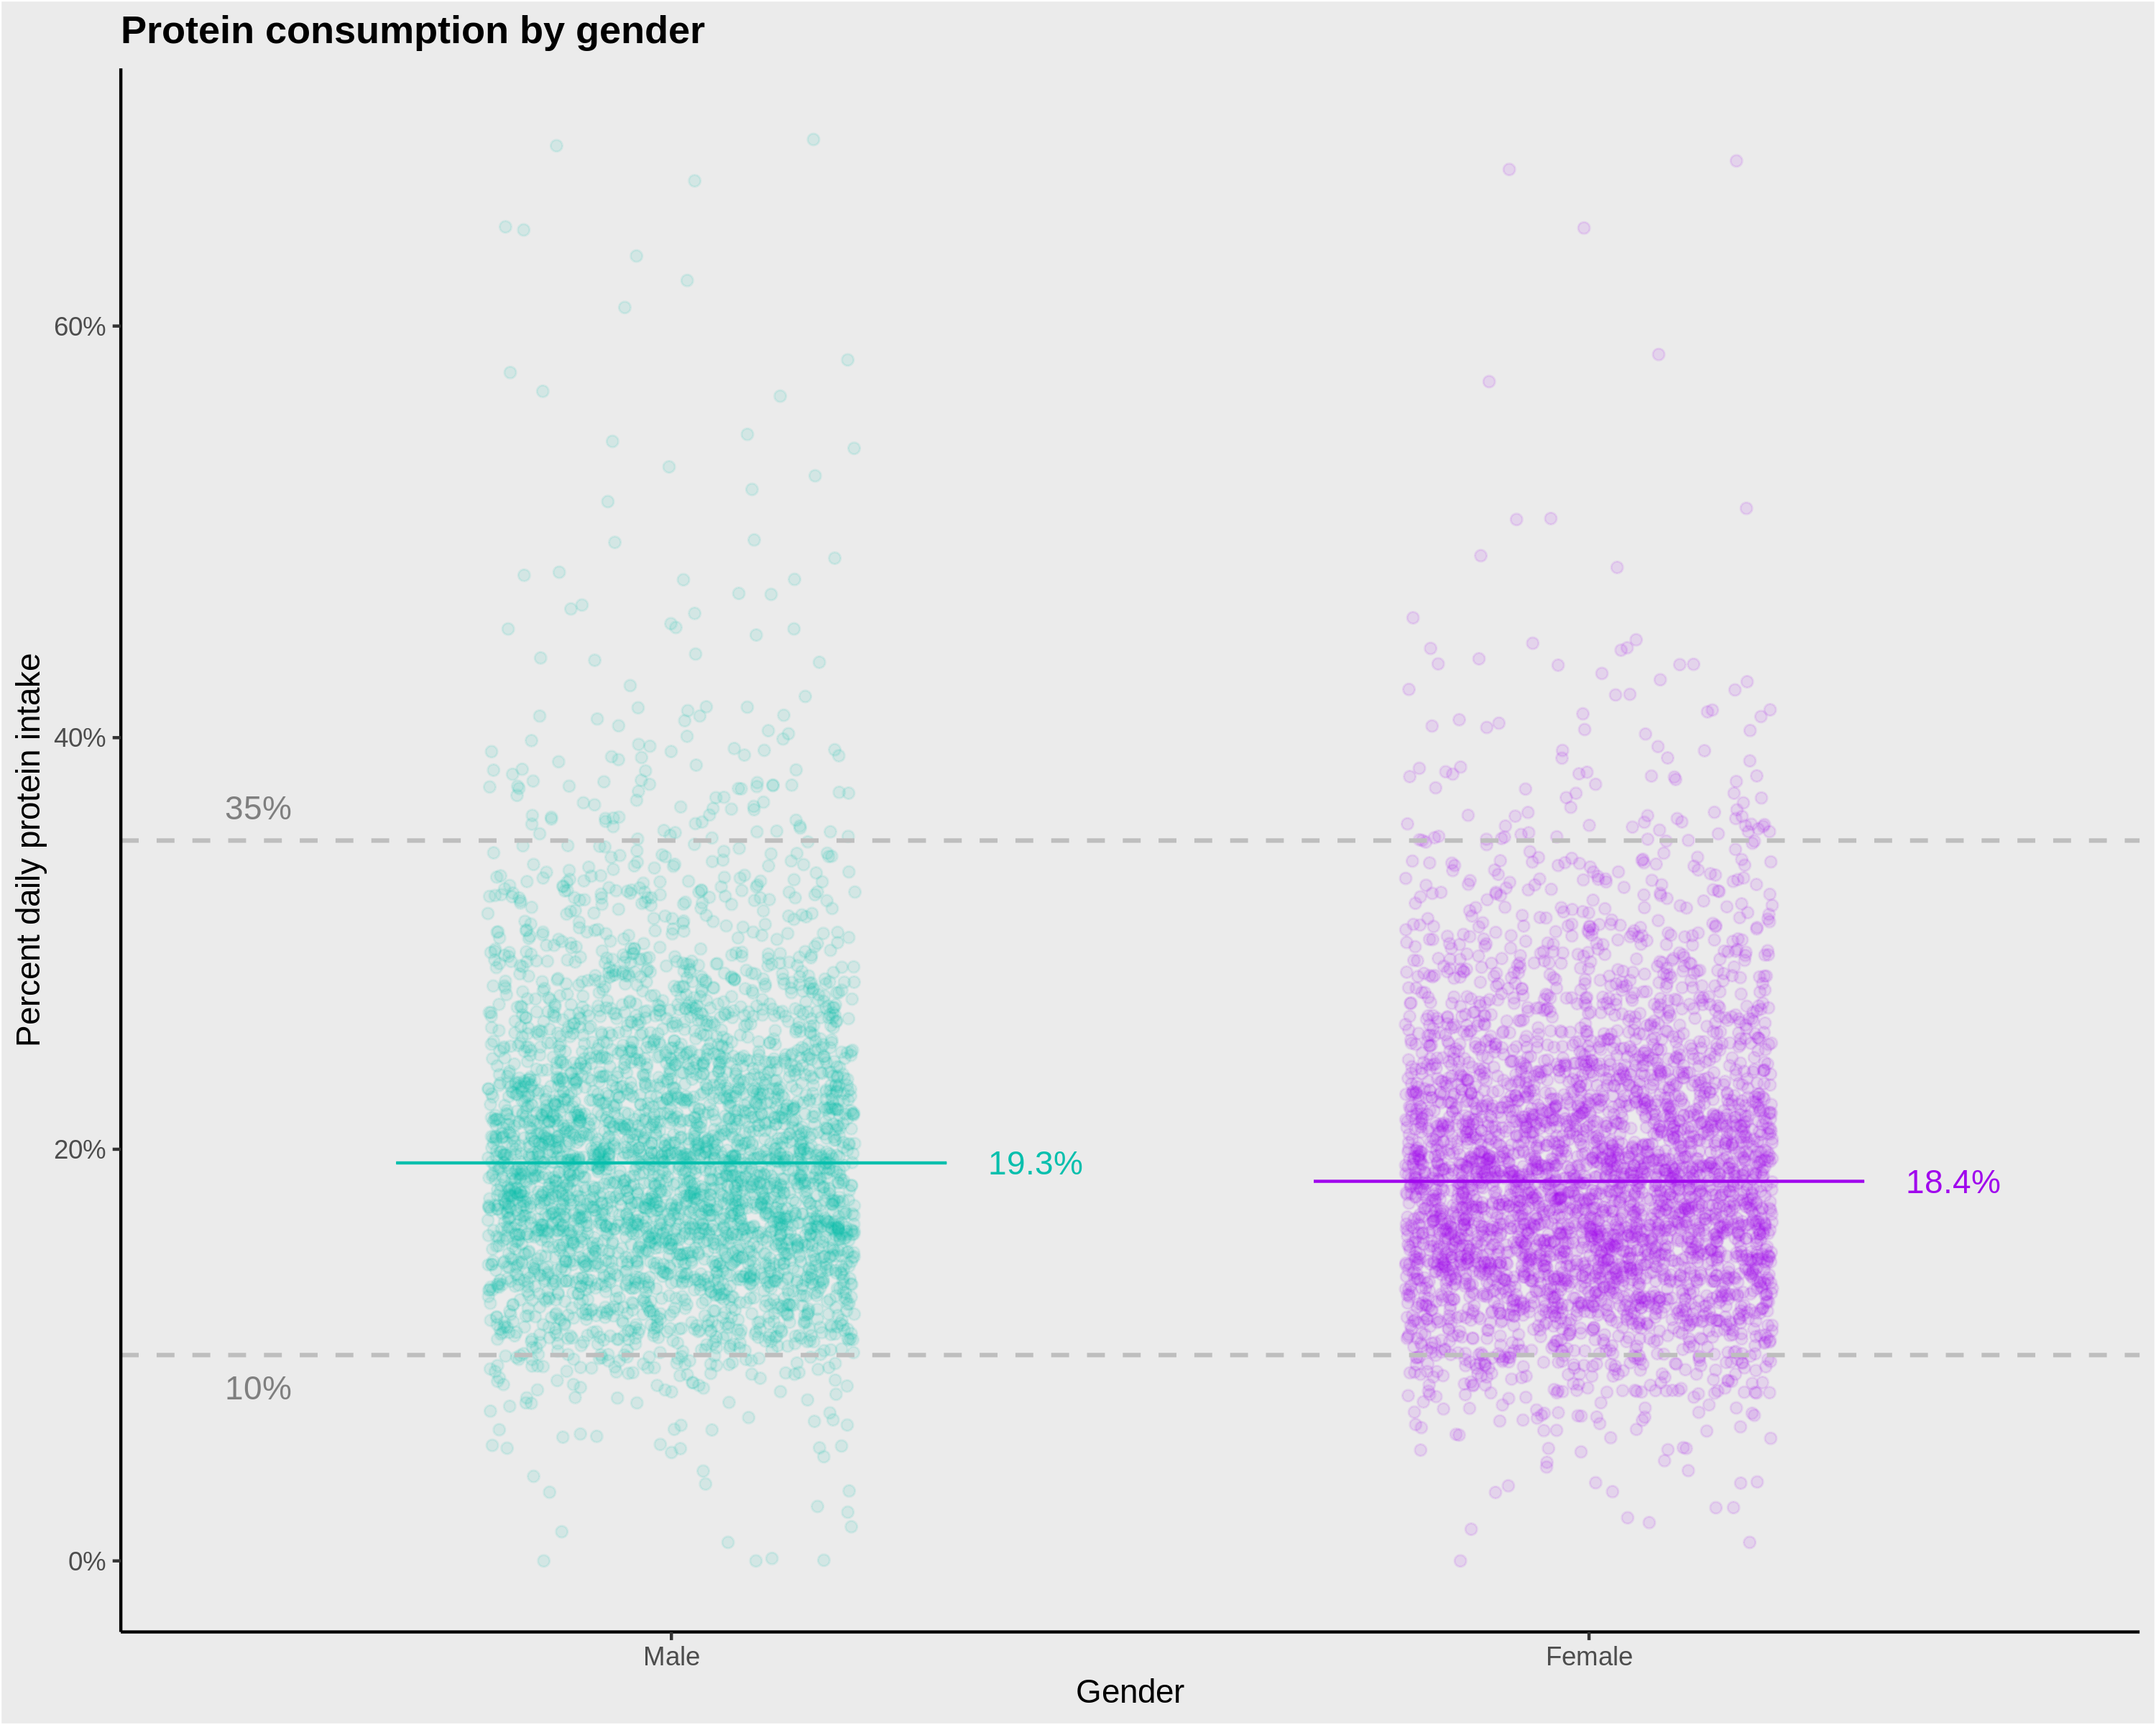

In [39]:
nutrition = nhanes_nutr |> 
  select(SEQN, DR1TPROT,  DR1TCARB, DR1TTFAT) |> 
  inner_join(nhanes_demo |> select(SEQN, 
                                   Gender = RIAGENDR, 
                                   Age = RIDAGEYR, 
                                   `Race/Ethnicity` = RIDRETH3, 
                                   Education = DMDEDUC2,
                                   `Ratio of Family Income to Poverty` = INDFMPIR), 
             by = 'SEQN') 

nutrition_prop = nutrition |> 
  pivot_longer(DR1TPROT: DR1TTFAT, names_to = "Nutrient", values_to = "grams") |> 
  group_by(SEQN) |> 
  mutate(prop_nutr = grams/sum(grams)) |> 
  ungroup() |> 
  select(SEQN, Gender, `Ratio of Family Income to Poverty`, Nutrient, prop_nutr) |> 
  pivot_wider(names_from = Nutrient, values_from = prop_nutr) |> 
  mutate(Gender = as.factor(Gender) |> fct_recode(Male = '1',
                                       Female = '2'))
  

prot_med = nutrition_prop |>
  group_by(Gender) |>
  summarize(median_prot = median(DR1TPROT*100, na.rm = T), n = n())

nutrition_prop |> 
  ggplot(aes(x = Gender, y = DR1TPROT*100, color = Gender)) + 
  geom_jitter(width = .2, alpha = .1) +
  geom_crossbar(data = prot_med, mapping = aes(y = median_prot, ymin = median_prot, ymax = median_prot), 
                width = .6, size = .2) +
  geom_text_repel(data = prot_med, 
                  aes(y = median_prot, 
                      label = paste0(round(median_prot,1),'%'), 
                      hjust= -3.3),
                  min.segment.length = Inf) +
  geom_text_repel(data = data.frame(x = c("Male"), y = c(36.6)), 
                  aes(x, y, label = "35%"), 
                  nudge_x = -.45,
                  color = "gray50",
                  min.segment.length = Inf) + 
  geom_text_repel(data = data.frame(x = c("Male"), y = c(8.4)), 
                  aes(x, y, label = "10%"), 
                  nudge_x = -.45,
                  color = "gray50",
                  min.segment.length = Inf) +
  geom_hline(yintercept = 10, size = .7, linetype = 'dashed', color = "gray") +
  geom_hline(yintercept = 35, size = .7, linetype = 'dashed', color = 'gray') +
  labs(title = "Protein consumption by gender", y = "Percent daily protein intake") +
  scale_y_continuous(labels = number_format(suffix="%")) +
  scale_color_manual(values = c('#06bfad', '#a007ed')) +
  guides(color = "none") +
  theme_classic() +
  theme(plot.title = element_text(size = 13, face = 'bold'),
        plot.background = element_rect(fill="gray92"),
        panel.background = element_rect(fill="gray92"),
        panel.grid = element_line(color="gray"))
  
  
  

Protein consumption is an aspect of nutrition I thought may be valuable to investigate due to preconceived notions regarding gender differences. To be able to explore this relationship, I merged variables from the NHANES demographics and nutrient intake datasets. Plotting all the values for percent daily protein intake by gender category reveals relatively similar distribution of values among this sample. The median for males is 19.3% compared to 18.4% for females. Median percent daily protein intake for both males and females falls squarely within the recommended daily percentage of 10-35%. There seems to be a greater proportion of males that are outliers, whose protein consumption falls well above the recommended maximum.

## Comparison of Diets

Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_step()`).”


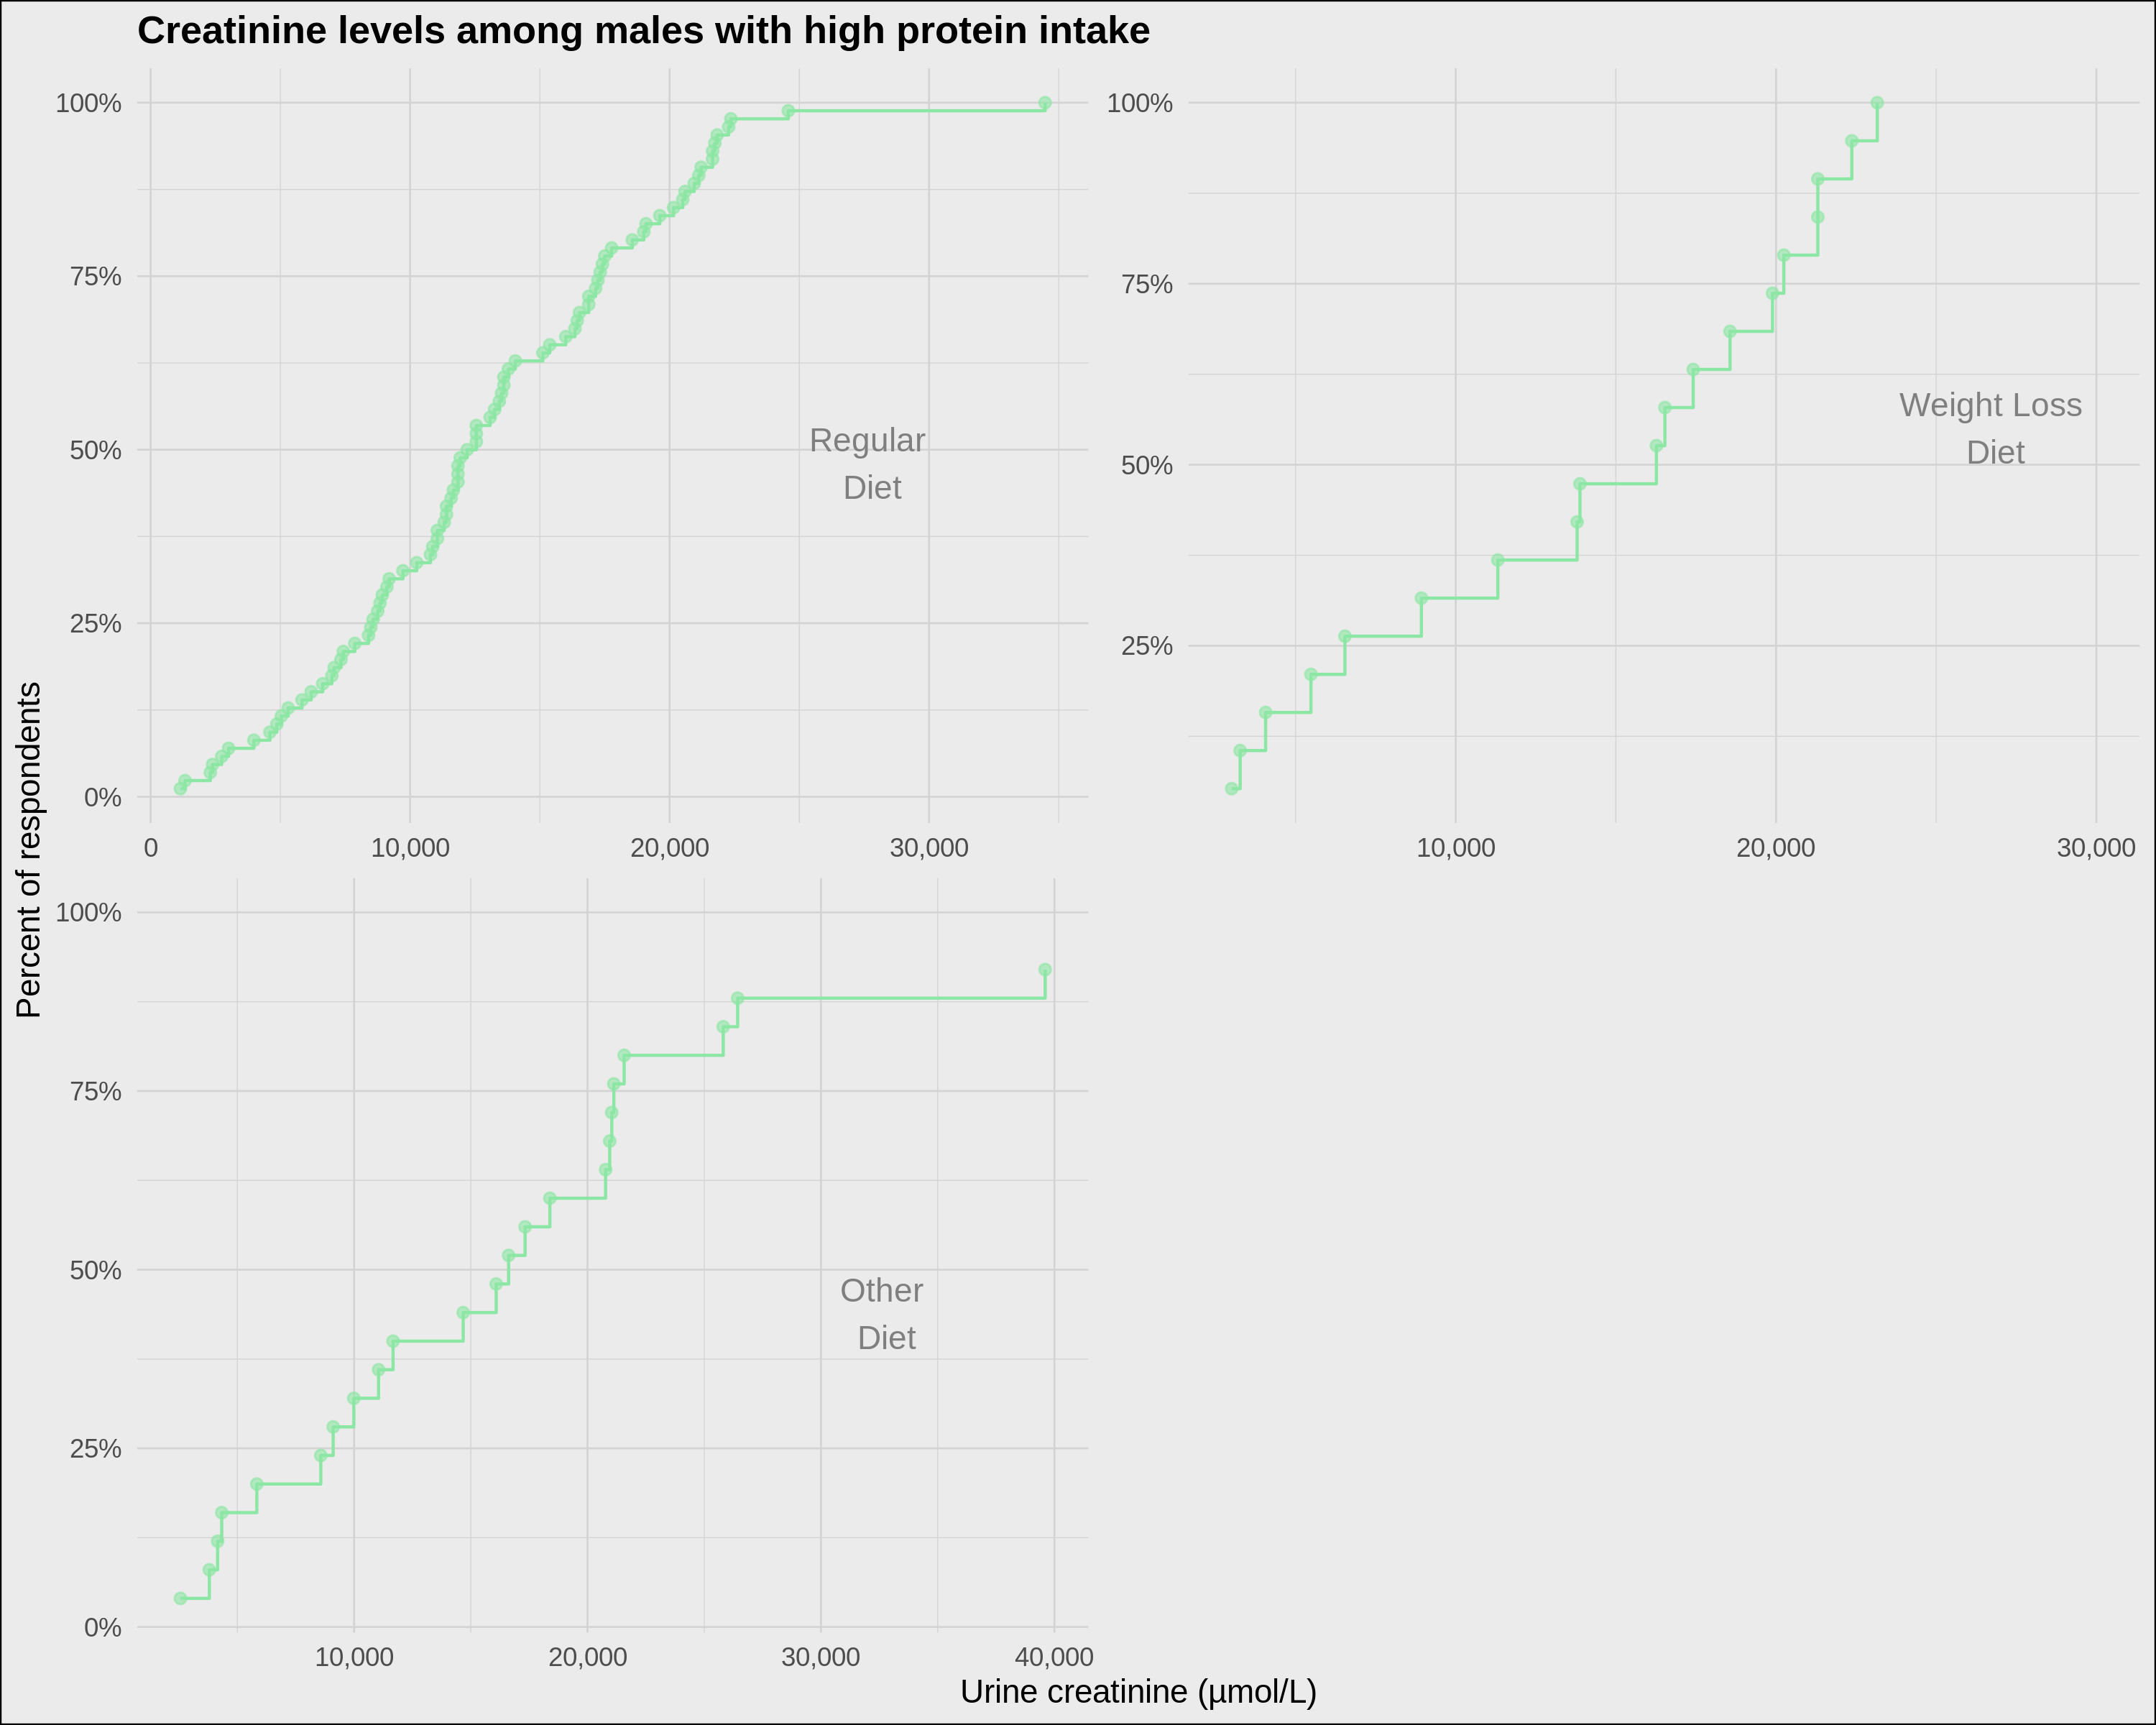

In [34]:
male_highProtein = nutrition_prop |> 
  filter(Gender == "Male", DR1TPROT > .35) |> 
  inner_join(diet_long |> select(SEQN, Diet), by = "SEQN") |> 
  mutate(Diet = Diet |> fct_infreq() |> fct_lump_n(2, other_level = "Other")) |> 
  inner_join(nhanes_labs |> select(SEQN, creatinine_mol = URXCRS), by = 'SEQN')

male_highProtein |> 
  arrange(creatinine_mol) |> 
  group_by(Diet) |> 
  mutate(cumulative_prop = row_number()/n()) |> 
  ungroup() |> 
  ggplot(aes(x = creatinine_mol, y = cumulative_prop*100)) + 
  geom_point(color = '#8ce6a4', alpha = .6)+
  geom_step(color = '#8ce6a4') +
  geom_text_repel(data = data.frame(Diet = c("Regular", "Weight Loss", "Other") |> fct_infreq() |> fct_rev(), 
                                    x = c(30000,30000,35000), y = c(55,55,50)),
                  aes(x, y, label = paste0(Diet, "\n Diet")),
                  nudge_x = -.45,
                  color = "gray50",
                  min.segment.length = Inf) +
  labs(x = "Urine creatinine (µmol/L)", y = "Percent of respondents",title = "Creatinine levels among males with high protein intake") +
  scale_x_continuous(labels = comma_format()) +
  scale_y_continuous(labels = number_format(suffix="%")) +
  theme_minimal() +
  theme(plot.title = element_text(size = 13, face = 'bold'),
        plot.background = element_rect(fill="gray92"),
        panel.grid = element_line(color="lightgray", size = .3),
        strip.text.x = element_blank()) +
  facet_wrap(~Diet, ncol = 2, scales = "free") 

Since earlier it appeared that a higher proportion of males had high protein consumption, I chose to look into creatinine levels among the subset of males whose protein intake exceeded the upper end of the recommended range. Creatinine levels are somewhat affected by protein. Additionally, factoring in diet may help elucidate the distribution of creatinine levels. The figures above illustrate how a larger percentage of respondents on regular diets and other non-weight loss diets have higher creatinine levels, whereas all those on the weight loss diet had creatinine levels below about 22,000 µmol/L.
